In [1]:
from tournament.agents.constant import AllC, AllD
from tournament.agents.pavlov import Pavlov
from tournament.agents.q_learning.dqn import DeepQLearner
from tournament.agents.tft import TFTT, GenerousTFT, TitForTat
from tournament.environments.single import SingleRuleBasedAgentEnvironment
from tournament.environments.multiple import MultipleRuleBasedAgentEnvironment
from tournament.agents.agents import AGENTS
from tournament.agents.axelrod_first import (
    Davis,
    Downing,
    Feld,
    Grofman,
    Grudger,
    Joss,
    Nydegger,
    Shubik,
    SteinAndRapoport,
    TidemanAndChieruzzi,
    Tullock,
)
from tournament.agents.tft import (
    TFTT,
    TTFT,
    GenerousTFT,
    GradualTFT,
    OmegaTFT,
    TitForTat,
)
from tournament.tournament import RoundRobinTournament

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams["figure.figsize"] = (20, 12)
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# env = SingleRuleBasedAgentEnvironment(TitForTat)
env = MultipleRuleBasedAgentEnvironment([
    TitForTat,
    # AllC,
    TFTT,
    TTFT,
    GenerousTFT,
    # GradualTFT,
    OmegaTFT,
])

In [3]:
class QNetwork(nn.Module):
    def __init__(self, lookback):
        super().__init__()

        self.flatten = nn.Flatten()
        self.gru = nn.GRU(2, 2, 2, batch_first=True)
        self.layer4 = nn.Linear(2 * lookback, 2)

        nn.init.kaiming_uniform_(self.layer4.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = x.unsqueeze(dim=0)
        x, hn = self.gru(x)
        x = self.flatten(x)
        x = torch.relu(self.layer4(x))

        return x

class QLearningTest(DeepQLearner):
    lookback = 4
    epsilon = 0.15

    def __init__(self):
        super().__init__()

        self._learning_rate = 0.01
        self._q_network = QNetwork(self.lookback)


agent = QLearningTest()

In [4]:
env.train(
    trainee=agent,
    continuation_probability=1,
    limit=250,
    noise=0,
    repetitions=5,
    epochs=20,
)

[16:12:09] Commencement of training.
[16:12:09] Training against OmegaTFT
[16:12:22] Training against GenerousTFT
[16:12:33] Training against TTFT
[16:12:43] Training against TFTT
[16:12:54] Training against TitForTat
[16:13:05] Completed epoch 1: 9.57952
[16:13:05] Training against TFTT
[16:13:15] Training against GenerousTFT
[16:13:26] Training against TTFT
[16:13:36] Training against TitForTat
[16:13:47] Training against OmegaTFT
[16:13:58] Completed epoch 2: 9.61
[16:13:58] Training against TTFT
[16:14:09] Training against OmegaTFT
[16:14:26] Training against TFTT
[16:14:38] Training against TitForTat
[16:14:51] Training against GenerousTFT
[16:15:03] Completed epoch 3: 9.608586666666667
[16:15:03] Training against OmegaTFT
[16:15:17] Training against TFTT
[16:15:33] Training against TitForTat
[16:15:48] Training against TTFT
[16:16:07] Training against GenerousTFT
[16:16:22] Completed epoch 4: 9.6174
[16:16:22] Training against TitForTat
[16:16:35] Training against OmegaTFT
[16:16

KeyboardInterrupt: 

In [5]:
print(agent._q_network)
print(env.counts)

s = sum(env.counts.values())

print({a: env.counts[a] / s for a in env.counts})

QNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (gru): GRU(2, 2, num_layers=2, batch_first=True)
  (layer4): Linear(in_features=16, out_features=2, bias=True)
)
{<Action.COOPERATE: 0>: 28684, <Action.DEFECT: 1>: 3145}
{<Action.COOPERATE: 0>: 0.9011907380062207, <Action.DEFECT: 1>: 0.09880926199377926}


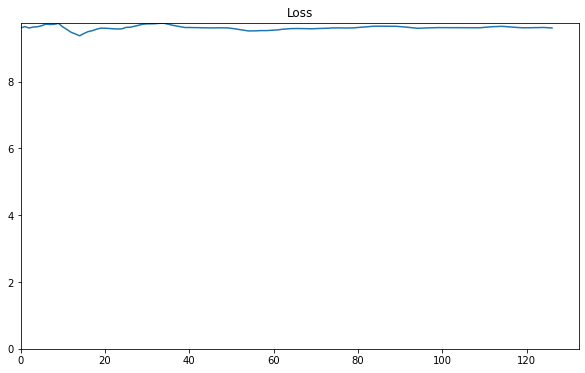

In [6]:
plt.title("Loss")
plt.plot(env.metric_history)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

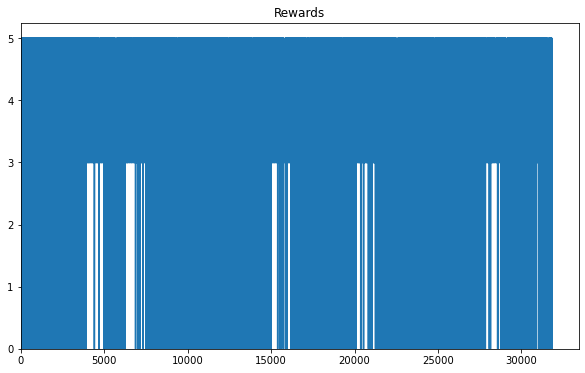

In [7]:
plt.title("Rewards")
plt.plot(env.rewards)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

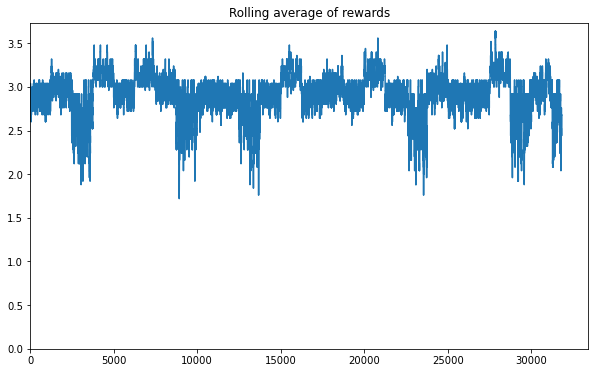

In [8]:
N = 25

plt.title("Rolling average of rewards")
plt.plot(np.convolve(env.rewards, np.ones(N), mode='valid') / N)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

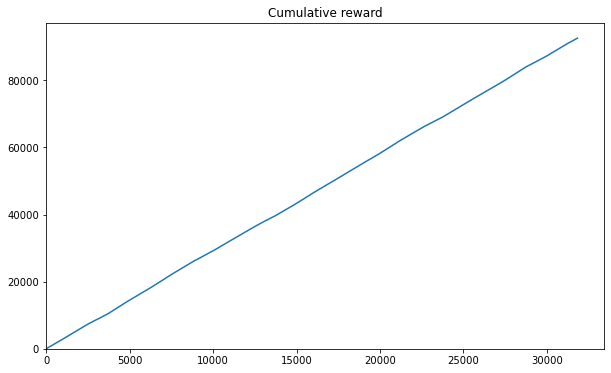

In [9]:
plt.title("Cumulative reward")
plt.plot(np.cumsum(env.rewards))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

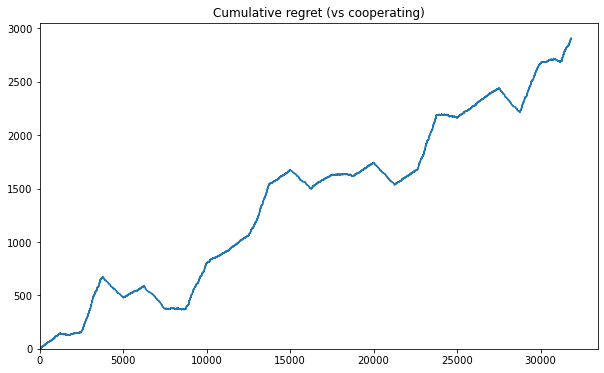

In [10]:
plt.title("Cumulative regret (vs cooperating)")
plt.plot(np.cumsum(3 - np.array(env.rewards)))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

In [11]:
torch.save(agent._q_network.state_dict(), "model-gru-1.pt")

In [12]:
agent._q_network.eval()

QNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (gru): GRU(2, 2, num_layers=2, batch_first=True)
  (layer4): Linear(in_features=16, out_features=2, bias=True)
)

In [13]:
tournament = RoundRobinTournament(AGENTS, [agent])

scores, times = tournament.play(
    continuation_probability=0.99654, repetitions=20, jobs=12
)

results = [
    (agent, round(sum(scores[agent]) / len(scores[agent])), sum(times[agent]))
    for agent in scores
]
results.sort(key=lambda x: x[1], reverse=True)

for c, score, time in results:
    print(f"{c.__name__:<30} {score:<20} {time:<20}")


100%|██████████| 961/961 [06:55<00:00,  2.31matches/s] 

Shubik                         821                  18.736626           
Borufsen                       814                  17.649079           
GenerousTFT                    803                  12.968047000000002  
OmegaTFT                       794                  15.540087           
Weiner                 790                  26.779210000000006  
TitForTat                      786                  15.220348000000001  
GradualTFT                     785                  62.9642             
TTFT                           783                  13.318593           
TidemanAndChieruzzi2    779                  15.607171999999998  
Leyvraz                        776                  36.537574           
Davis                          775                  17.976368           
SecondByBlackK83R              771                  22.702706000000003  
TidemanAndChieruzzi            770                  17.807189           
Grofman                        767                  17.54807600000